## Import Packages

In [1]:
# Web - Scraping and API Requests
import requests
from httpx import AsyncClient, Response
from parsel import Selector
import parsel
import jmespath
import asyncio

# Data Manipulation and Analysis
import pandas as pd
from pprint import pprint 
import json
from typing import List
from typing import TypedDict

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Regressions
from sklearn.linear_model import LinearRegression


# Database Connection
from sqlalchemy import create_engine
from sqlalchemy import inspect, text

# File and System Operations
import os
import sys

## Other Setup

In [2]:
# This allows one to reload the custom package without having to install it again
%load_ext autoreload 

In [3]:
# this allows one to reload the custom package without having to install it again
%autoreload 1

sys.path.insert(0,'../src/')

# Import the custom package and sub-packages
%aimport rental_utils
%aimport rental_utils.functions
%aimport rental_utils.sql_queries

In [4]:
pd.set_option('display.max_columns', None) # Display all columns in any given DataFrame

### Import Custom Packages

In [5]:
from rental_utils import sql_queries as sqlq
from rental_utils import functions as rent

## Analyse the Data

### Get the Data from the Database

In [6]:
engine = sqlq.get_sql_engine("../data/properties.db")

In [7]:
with engine.connect() as connection:
    properties_data = pd.read_sql(text(sqlq.GET_PROPERTIES_DATA_SQL_QUERY), connection)

#### Clean the Data So that Regressions can be Run

In [8]:


def clean_for_reg(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the input DataFrame for regression analysis.

    Inputs:
        df (pd.DataFrame): The input DataFrame containing property data.
    Output:
        pd.DataFrame: The cleaned DataFrame suitable for regression.
    """
    # Adjust price_per_bed to monthly if priceFrequency is 'weekly', else keep as is
    df = df.copy()
    df["price_per_bed"] = df.apply(
        lambda row: row["price_per_bed"] * 52 / 12 if row["priceFrequency"] == "weekly" else row["price_per_bed"],
        axis=1
    )

    # Filter for rows where priceFrequency is 'monthly' or 'weekly' (after adjustment)
    reg_data = df[df["priceFrequency"].isin(["monthly", "weekly"])]

    # Eliminate all rows where travel_time is non-numeric or not between 60 and 5400 seconds
    reg_data = reg_data[pd.to_numeric(reg_data["travel_time"], errors="coerce").between(60, 5400)]

    # Eliminate all rows where bathrooms is non-numeric or not between 1 and 6
    reg_data = reg_data[pd.to_numeric(reg_data["bathrooms"], errors="coerce").between(1, 6)]

    # Filter for rows where price_per_bed is a valid number between 100 and 10,000
    reg_data = reg_data[pd.to_numeric(reg_data["price_per_bed"], errors="coerce").between(100, 10000)]
    
    # return the clean data
    return reg_data

reg_data = clean_for_reg(properties_data)
reg_data.head()

,id,price_per_bed,predicted_price_per_bed,travel_time,distance,bedrooms,bathrooms,numberOfImages,displayAddress,latitude,longitude,propertySubType,listingUpdateReason,listingUpdateDate,priceAmount,priceFrequency,premiumListing,featuredProperty,transactionType,students,displaySize,propertyUrl,firstVisibleDate,addedOrReduced,propertyTypeFullDescription
0,50425854,2600.000000,2085.823315,1059,0,1,1.0,29,"St. George Wharf, London, SW8",51.486140,-0.125480,Apartment,new,2025-07-01T15:04:28Z,600,weekly,0,0,rent,1,52 sq. m.,/properties/50425854#/?channel=RES_LET,2017-09-07T14:00:35Z,Added today,1 bedroom apartment
1,80209919,1066.000000,1918.817457,1368,0,3,1.0,22,"Dunton Road, London, SE1",51.492600,-0.074660,Terraced,new,2025-07-01T15:46:11Z,738,weekly,0,0,rent,0,70 sq. m.,/properties/80209919#/?channel=RES_LET,2019-03-18T14:08:31Z,Added today,3 bedroom terraced house
2,82567577,2899.000000,1808.561162,1572,0,1,1.0,26,"Riverlight Quay, London, SW8",51.480250,-0.133930,Apartment,new,2025-07-01T14:57:09Z,669,weekly,0,0,rent,0,47 sq. m.,/properties/82567577#/?channel=RES_LET,2019-06-13T16:25:32Z,Added today,1 bedroom apartment
3,83161844,1275.000000,1524.247255,2103,0,2,2.0,7,"Greyhound Road, London, W6",51.484998,-0.218458,Apartment,new,2025-07-01T15:45:11Z,2550,monthly,0,0,rent,0,90 sq. m.,/properties/83161844#/?channel=RES_LET,2019-07-09T02:03:16Z,Added today,2 bedroom apartment
4,86137431,1993.333333,1832.856785,1532,0,2,2.0,22,"The Modern, Embassy Gardens, London, SW11",51.481964,-0.130297,Apartment,new,2025-07-01T17:30:02Z,920,weekly,0,0,rent,0,,/properties/86137431#/?channel=RES_LET,2023-05-17T09:25:04Z,Added today,2 bedroom apartment


### Make A Scatter Plot of Rent Per Bed Against Travel Time (With a Line of Best Fit)

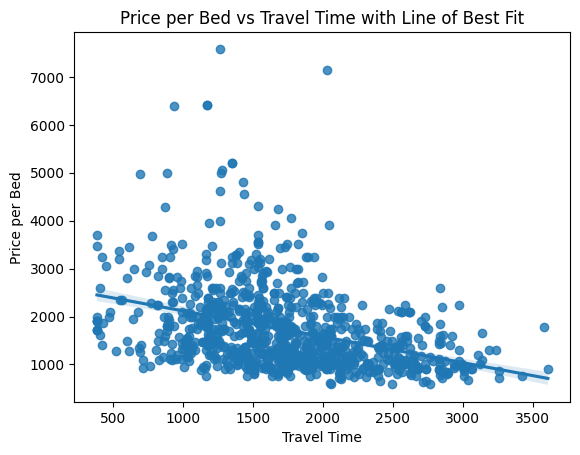

In [9]:
sns.regplot(x='travel_time', y='price_per_bed', data=reg_data)
plt.xlabel('Travel Time')
plt.ylabel('Price per Bed')
plt.title('Price per Bed vs Travel Time with Line of Best Fit')
plt.show()

### Make Predictions of Rent Per Bed to See Which Flats are Underpriced

#### Make the Predictions

In [10]:
# Select features and target
X = reg_data[['travel_time', 'bathrooms']]
y = reg_data['price_per_bed']

# Create and fit model
model = LinearRegression()
model.fit(X, y)

# To generate predictions 
predictions = model.predict(X)

# Add predictions to dataframe
reg_data.loc[:,'predicted_price_per_bed'] = predictions





#### Save out the Data With Predictions

In [11]:
##### create a temporary table
sqlq.make_table(reg_data[["id", "predicted_price_per_bed"]], "temp_updates", engine, if_exists="replace")

##### run a single SQL statement to update properties_data using temp_updates (fill in missing data)
with engine.begin() as connection:
    connection.execute(text(sqlq.UPDATE_PREDICTED_PRICE))

#### Check if the Predictions can be Extracted Properly

In [12]:
with engine.connect() as connection:
    test = pd.read_sql(text(sqlq.GET_PROPERTIES_DATA_SQL_QUERY), connection)
test.head()

,id,price_per_bed,predicted_price_per_bed,travel_time,distance,bedrooms,bathrooms,numberOfImages,displayAddress,latitude,longitude,propertySubType,listingUpdateReason,listingUpdateDate,priceAmount,priceFrequency,premiumListing,featuredProperty,transactionType,students,displaySize,propertyUrl,firstVisibleDate,addedOrReduced,propertyTypeFullDescription
0,50425854,600.0,2085.823315,1059,0,1,1.0,29,"St. George Wharf, London, SW8",51.486140,-0.125480,Apartment,new,2025-07-01T15:04:28Z,600,weekly,0,0,rent,1,52 sq. m.,/properties/50425854#/?channel=RES_LET,2017-09-07T14:00:35Z,Added today,1 bedroom apartment
1,80209919,246.0,1918.817457,1368,0,3,1.0,22,"Dunton Road, London, SE1",51.492600,-0.074660,Terraced,new,2025-07-01T15:46:11Z,738,weekly,0,0,rent,0,70 sq. m.,/properties/80209919#/?channel=RES_LET,2019-03-18T14:08:31Z,Added today,3 bedroom terraced house
2,82567577,669.0,1808.561162,1572,0,1,1.0,26,"Riverlight Quay, London, SW8",51.480250,-0.133930,Apartment,new,2025-07-01T14:57:09Z,669,weekly,0,0,rent,0,47 sq. m.,/properties/82567577#/?channel=RES_LET,2019-06-13T16:25:32Z,Added today,1 bedroom apartment
3,83161844,1275.0,1524.247255,2103,0,2,2.0,7,"Greyhound Road, London, W6",51.484998,-0.218458,Apartment,new,2025-07-01T15:45:11Z,2550,monthly,0,0,rent,0,90 sq. m.,/properties/83161844#/?channel=RES_LET,2019-07-09T02:03:16Z,Added today,2 bedroom apartment
4,86137431,460.0,1832.856785,1532,0,2,2.0,22,"The Modern, Embassy Gardens, London, SW11",51.481964,-0.130297,Apartment,new,2025-07-01T17:30:02Z,920,weekly,0,0,rent,0,,/properties/86137431#/?channel=RES_LET,2023-05-17T09:25:04Z,Added today,2 bedroom apartment


### Save this out to Supabase as Well

### Finding the correct file directory for the database credentials json with the api key and password


In [ ]:
current_dir = os.path.dirname(os.path.abspath("NB04_Analyse_Data.ipynb"))
sys.path.insert(0,os.path.join(current_dir, '..'))

credentials_file_path = os.path.join(current_dir, '..', "supabase_credentials.json")

# open the  credentials file and load the data into a variable
with open(credentials_file_path, "r") as f:
    credentials = json.load(f)

#### Connect to the SupaBase Engine

In [16]:
# connect to the database
supabase_engine = sqlq.get_supabase_engine(
    user="postgres",
    password=credentials['password'],
    host=credentials['host'],
    port=5432,
    database="postgres"
)

### Create an Empty Table and Fill it with the Right Data

In [17]:
## Drop the table if we wish
with supabase_engine.begin() as connection:
    connection.execute(text(sqlq.DROP_PROPERTIES_TABLE_SQL_QUERY))

In [18]:
## Execute the CREATE TABLE query to create a blank table if it doesn't already exist
with supabase_engine.begin() as connection:
    connection.execute(text(sqlq.CREATE_TABLE_SQL_QUERY))

In [20]:


## find the ids that already exist
with supabase_engine.connect() as conn:
    existing_ids = conn.execute(text("SELECT id FROM properties_data")).fetchall()
## filter out only the ids that will be unique to the existing table
existing_ids = {row[0] for row in existing_ids}
new_rows = reg_data[~reg_data['id'].isin(existing_ids)]



In [21]:
# fill in the data into the table
sqlq.make_table(new_rows, "properties_data", supabase_engine)

### Test if Can be Read Back In Properly

In [22]:
with supabase_engine.connect() as connection:
    test = pd.read_sql(text(sqlq.GET_PROPERTIES_DATA_SQL_QUERY), connection)
test.head()

,id,price_per_bed,predicted_price_per_bed,travel_time,distance,bedrooms,bathrooms,numberOfImages,displayAddress,latitude,longitude,propertySubType,listingUpdateReason,listingUpdateDate,priceAmount,priceFrequency,premiumListing,featuredProperty,transactionType,students,displaySize,propertyUrl,firstVisibleDate,addedOrReduced,propertyTypeFullDescription
0,50425854,2600.00,2085.82,1059,0,1,1,29,"St. George Wharf, London, SW8",51.4861,-0.125480,Apartment,new,2025-07-01T15:04:28Z,600,weekly,0,0,rent,1,52 sq. m.,/properties/50425854#/?channel=RES_LET,2017-09-07T14:00:35Z,Added today,1 bedroom apartment
1,80209919,1066.00,1918.82,1368,0,3,1,22,"Dunton Road, London, SE1",51.4926,-0.074660,Terraced,new,2025-07-01T15:46:11Z,738,weekly,0,0,rent,0,70 sq. m.,/properties/80209919#/?channel=RES_LET,2019-03-18T14:08:31Z,Added today,3 bedroom terraced house
2,82567577,2899.00,1808.56,1572,0,1,1,26,"Riverlight Quay, London, SW8",51.4803,-0.133930,Apartment,new,2025-07-01T14:57:09Z,669,weekly,0,0,rent,0,47 sq. m.,/properties/82567577#/?channel=RES_LET,2019-06-13T16:25:32Z,Added today,1 bedroom apartment
3,83161844,1275.00,1524.25,2103,0,2,2,7,"Greyhound Road, London, W6",51.4850,-0.218458,Apartment,new,2025-07-01T15:45:11Z,2550,monthly,0,0,rent,0,90 sq. m.,/properties/83161844#/?channel=RES_LET,2019-07-09T02:03:16Z,Added today,2 bedroom apartment
4,86137431,1993.33,1832.86,1532,0,2,2,22,"The Modern, Embassy Gardens, London, SW11",51.4820,-0.130297,Apartment,new,2025-07-01T17:30:02Z,920,weekly,0,0,rent,0,,/properties/86137431#/?channel=RES_LET,2023-05-17T09:25:04Z,Added today,2 bedroom apartment
